In [2]:
# importing relevant modules
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot   as plt
import librosa
import numpy as np
import json
from statistics import stdev

from pandas                import read_csv, to_datetime
from numpy                 import reshape, array
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers          import Dense, Dropout, LSTM, Input, TimeDistributed
from keras.models          import Model
from keras_tqdm            import TQDMNotebookCallback
from IPython.display       import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.callbacks       import EarlyStopping
from keras.layers import Conv2DTranspose

%matplotlib inline


Using TensorFlow backend.


In [3]:
samples_per_chunk = 300
num_chunks_per_slice = 65
num_chunks_per_beat = 8

In [4]:
def loadbeatmap(beatmap, num_beats, num_chunks_per_beat=8):
    if beatmap[len(beatmap)-5:len(beatmap)] != ".json":
        print("Beatmap file " + audio + " is not of type .json")
        return -1
    
    with open(beatmap) as f:
        data = json.load(f)
  
    notes = "_notes"
    time = "_time"
    line_index = "_lineIndex" #column number
    line_layer = "_lineLayer" #row number
    note_color = "_type" #0 is one color and 1 is the other
    cut_direction = "_cutDirection"#9 cut directions

    dim_0 = num_beats * num_chunks_per_beat
    
    # number of rows and columns in the playfield
    # number of cells in the playfield (each cell can hold at most 1 note)
    playfield_rows = 3
    playfield_cols = 4
    playfield_cell_count = playfield_rows * playfield_cols
    
    # number of colors (2): red, blue (order unknown)
    # number of directions notes can face (9): 
    # up, down, left, right, up-left, up-right, down-left, down-right, dot (order unknown)
    note_color_count = 2
    note_direction_count = 9
    
    # dimensions for a 'one-hot' representation of a single time unit (chunk)
    dim_1 = playfield_rows
    dim_2 = playfield_cols
    dim_3 = (note_color_count + 1) + note_direction_count
    
    # initialize matrix to zeros, then set the "no note" bit for each block at each timestep to 1
    outMatrix = np.zeros(shape=(dim_0, dim_1, dim_2, dim_3))
    outMatrix[:,:,:,0] = 1
    

    # for every note in the beatmap, set the color and direction bits for the proper cell to 1
    for n in range(len(data[notes])):
        entry = int(np.round(data[notes][n][time]*num_chunks_per_beat)) #convert time to row index by rounding to nearest 1/8 beat
        if data[notes][n][note_color] < 2:
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][note_color]+1] = 1
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [0] = 0
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][cut_direction]+3] = 1

    return outMatrix

In [5]:
def mean_center(x): 
    return (x - np.apply_along_axis(np.mean, 0, x) )

In [6]:
def loadsong(audio, samples_per_chunk=300, num_chunks_per_slice=65, num_chunks_per_beat=8, verbose=0):
    if audio[len(audio)-4:len(audio)] != ".ogg":
        print("Audio file " + audio + " is not of type .ogg")
        return -1
    
    y, sr = librosa.load(audio)
    
    song_length = librosa.get_duration(y=y,sr=sr) / 60.0
    tempo = np.round(librosa.beat.tempo(y, sr=sr))
    new_sample_rate = (tempo/200)*8000
    
    y = librosa.resample(y, sr, new_sample_rate)
    
    number_of_beats = int(tempo * song_length)
    
    return y[0:(len(y)//(samples_per_chunk*num_chunks_per_beat)*(samples_per_chunk*num_chunks_per_beat))], new_sample_rate, number_of_beats

In [7]:
def prep_song(song, sample_per_chunk = 300):
    song_y = song.reshape(len(song)//300,300)
    song_fft = np.abs(np.apply_along_axis(np.fft.fft, 1, song_y))[:,0:(int)(samples_per_chunk/2)+1]
    song_fft_mc = np.apply_along_axis(mean_center, 0, song_fft)
    return song_fft_mc

In [8]:
def append_song(init_song, init_beatmap, song_filepath, beatmap_filepath, num_chunks_per_beat = 8):
    loaded_song_y, loaded_song_sr, num_beats = loadsong(song_filepath)
    
    prepped_song = prep_song(loaded_song_y)
    
    loaded_beatmap = loadbeatmap(beatmap_filepath, num_beats)
    
    if init_song == None and init_beatmap == None:
        init_song = []
        init_beatmap = []
        
    for i in range(num_beats*num_chunks_per_beat-256):
        init_song.append(prepped_song[i:i+256]) 
    for i in range(num_beats*num_chunks_per_beat-256):
        init_beatmap.append(loaded_beatmap[i:i+256]) 
    
    init_song = np.array(init_song)
    init_beatmap = np.array(init_beatmap)
        
    return init_song, init_beatmap

In [9]:
def data_prep(song_list, beatmap_list):
    X, Y = append_song(None, None, song_list[0], beatmap_list[0])
    for x, y in zip(song_list[1:], beatmap_list[1:]):
        X, Y = append_song(X, Y, x, y)
    
    return X, Y

In [10]:
X, Y  = data_prep(["song.ogg"], ["Expert.json"]) #"song.ogg"], ["Expert.json", "Expert.json"])

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [11]:
X.shape

(3856, 256, 151)

In [13]:
Y.shape

(3856, 256, 3, 4, 12)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 256, 151)     0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 144, 32)      546048      input_20[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 144, 100)     53200       conv1d_31[0][0]                  
__________________________________________________________________________________________________
up_sampling1d_11 (UpSampling1D) (None, 288, 100)     0           lstm_19[0][0]                    
__________________________________________________________________________________________________
conv1d_32 

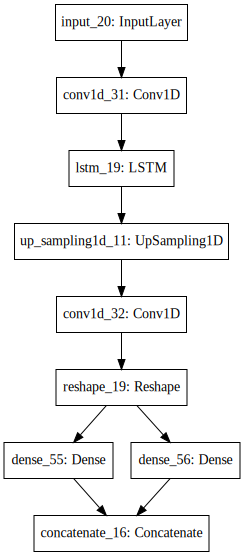

In [31]:
#Initial Model

lstm_size = 100
input_layer = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
cnn_layer = keras.layers.Conv1D(32, kernel_size=((X.shape[1] - 143)), 
                                activation='relu',
                                input_shape=[X.shape[1], X.shape[2]])
lstm_layer = keras.layers.LSTM(lstm_size, return_sequences = True)
dense_direction = keras.layers.Dense(9, activation ='softmax')
dense_color = keras.layers.Dense(3, activation = 'softmax')
deconv_layer = keras.layers.Conv1D(144, kernel_size=((X.shape[1] - 223)), activation='relu')
reshaper = keras.layers.Reshape((256, 3, 4, 12))
cnn_output = cnn_layer(input_layer)
lstm_output = lstm_layer(cnn_output)

lstm_output = keras.layers.UpSampling1D(2)(lstm_output)
deconv_output = deconv_layer(lstm_output)
reshape_output = reshaper(deconv_output)
direction_output = dense_direction(reshape_output)
color_output = dense_color(reshape_output)
dense_inputs = [direction_output, color_output]
final_output = keras.layers.concatenate(dense_inputs, axis = -1)

new_model = keras.Model(input_layer, final_output)
new_model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
new_model.summary()
SVG(model_to_dot(new_model).create(prog='dot',format='svg'))


In [33]:
batch_size = 225
epochs = 300
history = new_model.fit(X, Y,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0,
                   callbacks=[TQDMNotebookCallback()])
print('Accuracy:', model.evaluate(X,Y)[1]*100.0,'%')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NameError: name 'model' is not defined